In [1]:
import numpy as np
import networkx as nx
from copy import deepcopy
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Spatial autocorrelation optimization
we ran optimization on spatial autocorrelation (rho value described in paper) and assortativity.
The two optimization behaved similarly.
We used rho as a measure of spatial autocorrelation instead of assortativity, because the range of rho that a network can take depend on the topology, while assortativity does not (assortativity is a normalized value)
.

In [2]:
def getAttributeAssortativity(g,attr_name):
    # https://journals.plos.org/plosone/article/file?type=supplementary&id=info:doi/10.1371/journal.pone.0008090.s001
    # k_1: the degree (attribute) of the first node
    # k_2: the degree (attribute) of the second node
    m1 = 0
    m2 = 0
    m3 = 0
    n_edge = len(g.edges())
    for n1,n2 in g.edges():
        a1 = g.nodes()[n1][attr_name]
        a2 = g.nodes()[n2][attr_name]
        m1 += (a1*a2)
        m2 += (a1 + a2)
        m3 += (a1**2 + a2**2)
    m1 /= n_edge
    m2 /= n_edge
    m3 /= n_edge
    r = (4*m1 - m2**2) / (2*m3 - m2**2)
    return r

In [3]:
def getAutocorrelation(g):
    env_diff = 0
    for n1,n2 in g.edges():
        env_diff += abs(g.nodes()[n1]['E'] - g.nodes()[n2]['E'])
    return env_diff, env_diff/len(g.edges())

In [4]:
def envGen(n_com,m,n_sample,seed=None):
    g = nx.Graph(m)
    e = 1 / float(n_com)
    E_ls = np.arange(0,(n_com-1)*e+e,e)
    np.random.seed(seed)
    np.random.shuffle(E_ls)
    attr = {i:E_ls[i] for i in range(n_com)}
    nx.set_node_attributes(g,attr,"E")
    ASall = []
    ASedge = []
    assort = [getAttributeAssortativity(g,'E')]
    AS = getAutocorrelation(g)
    ASall.append(AS[0])
    ASedge.append(AS[1])
    for i in range(10000):
        n_ls = np.random.choice(range(n_com),n_sample,replace=False)
        nPair = int(n_sample/2)
        a = np.random.choice(n_ls,nPair,replace=False)
        b = [x for x in n_ls if x not in a]
        np.random.shuffle(a)
        np.random.shuffle(b)
        gcopy = deepcopy(g)
        for n1,n2 in zip(a,b): # swap environmental conditions
            gcopy.nodes()[n1]['E'] = g.nodes()[n2]['E']
            gcopy.nodes()[n2]['E'] = g.nodes()[n1]['E']
        AS_copy = getAutocorrelation(gcopy)
        if AS_copy[0] < ASall[-1]:
            g = gcopy # update g
            ASall.append(AS_copy[0])
            ASedge.append(AS_copy[1])
            assort.append(getAttributeAssortativity(gcopy,'E'))
        else:
            ASall.append(ASall[-1])
            ASedge.append(ASedge[-1])
            assort.append(assort[-1])
    attr = dict(g.nodes(data='E'))
    return ASall,ASedge,g,attr,assort

In [5]:
def envGen_assort(n_com,m,n_sample,seed=None):
    g = nx.Graph(m)
    e = 1 / float(n_com)
    E_ls = np.arange(0,(n_com-1)*e+e,e)
    np.random.seed(seed)
    np.random.shuffle(E_ls)
    attr = {i:E_ls[i] for i in range(n_com)}
    nx.set_node_attributes(g,attr,"E")
    assort = []
    ASall = []
    assort.append(getAttributeAssortativity(g,'E'))
    ASall.append(getAutocorrelation(g)[0])
    for i in range(10000):
        n_ls = np.random.choice(range(n_com),n_sample,replace=False)
        nPair = int(n_sample/2)
        a = np.random.choice(n_ls,nPair,replace=False)
        b = [x for x in n_ls if x not in a]
        np.random.shuffle(a)
        np.random.shuffle(b)
        gcopy = deepcopy(g)
        for n1,n2 in zip(a,b): # swap environmental conditions
            gcopy.nodes()[n1]['E'] = g.nodes()[n2]['E']
            gcopy.nodes()[n2]['E'] = g.nodes()[n1]['E']
        assort_copy = getAttributeAssortativity(gcopy,'E')
        if assort_copy > assort[-1]:
            g = gcopy # update g
            assort.append(assort_copy)
            ASall.append(getAutocorrelation(gcopy)[0])
        else:
            assort.append(assort[-1])
            ASall.append(ASall[-1])
    attr = dict(g.nodes(data='E'))
    return assort,g,attr,ASall

In [6]:
def Plot(g,attr_ls):
    pos = nx.kamada_kawai_layout(g)
    #nx.draw(g,pos,node_color=list(attr_ls.values()),cmap=plt.cm.coolwarm,node_size=50)
    cmap = plt.cm.coolwarm
    colors = list(attr_ls.values())
    vmin = min(colors)
    vmax= max(colors)
    nx.draw(g,pos,node_color=colors,cmap=cmap,node_size=50)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin,vmax=vmax))
    sm._A = []
    plt.colorbar(sm)

(1666.4999999999816, 0.33666666666666295)
-0.010101010101017731


<IPython.core.display.Javascript object>


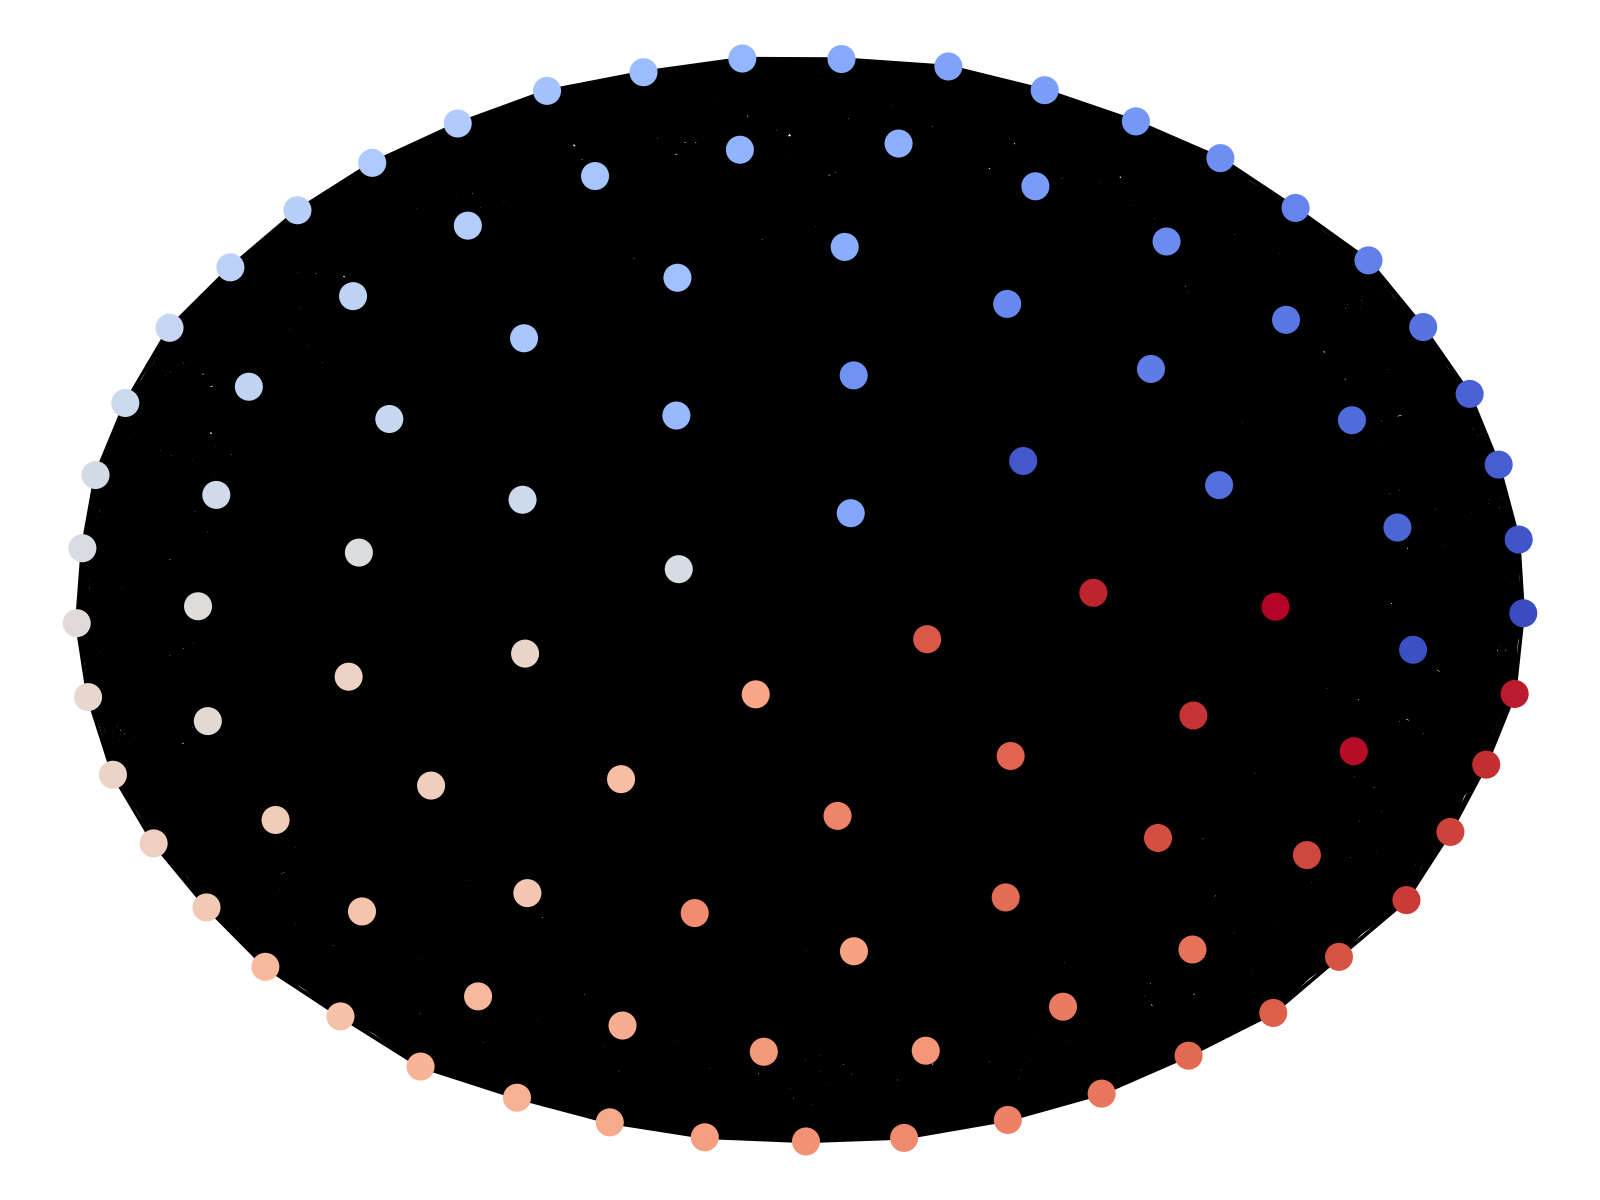

In [40]:
fname = "N100complete.txt"
n_com = 100
m = np.loadtxt(fname,delimiter=' ')
n_sample = 4 # the number of nodes sample for env. condition swapping. Choose an even number
e = 1 / float(n_com)
E_ls = np.arange(0,(n_com-1)*e+e,e)
attr = {i:E_ls[i] for i in range(n_com)}
g = nx.Graph(m)
nx.set_node_attributes(g,attr,"E")
AS = getAutocorrelation(g)
print(AS)
print(getAttributeAssortativity(g,'E'))
#np.savetxt("N100complete_"+str(AS),list(attr.values()))
plt.figure()
Plot(g,attr)
plt.show()

<IPython.core.display.Javascript object>


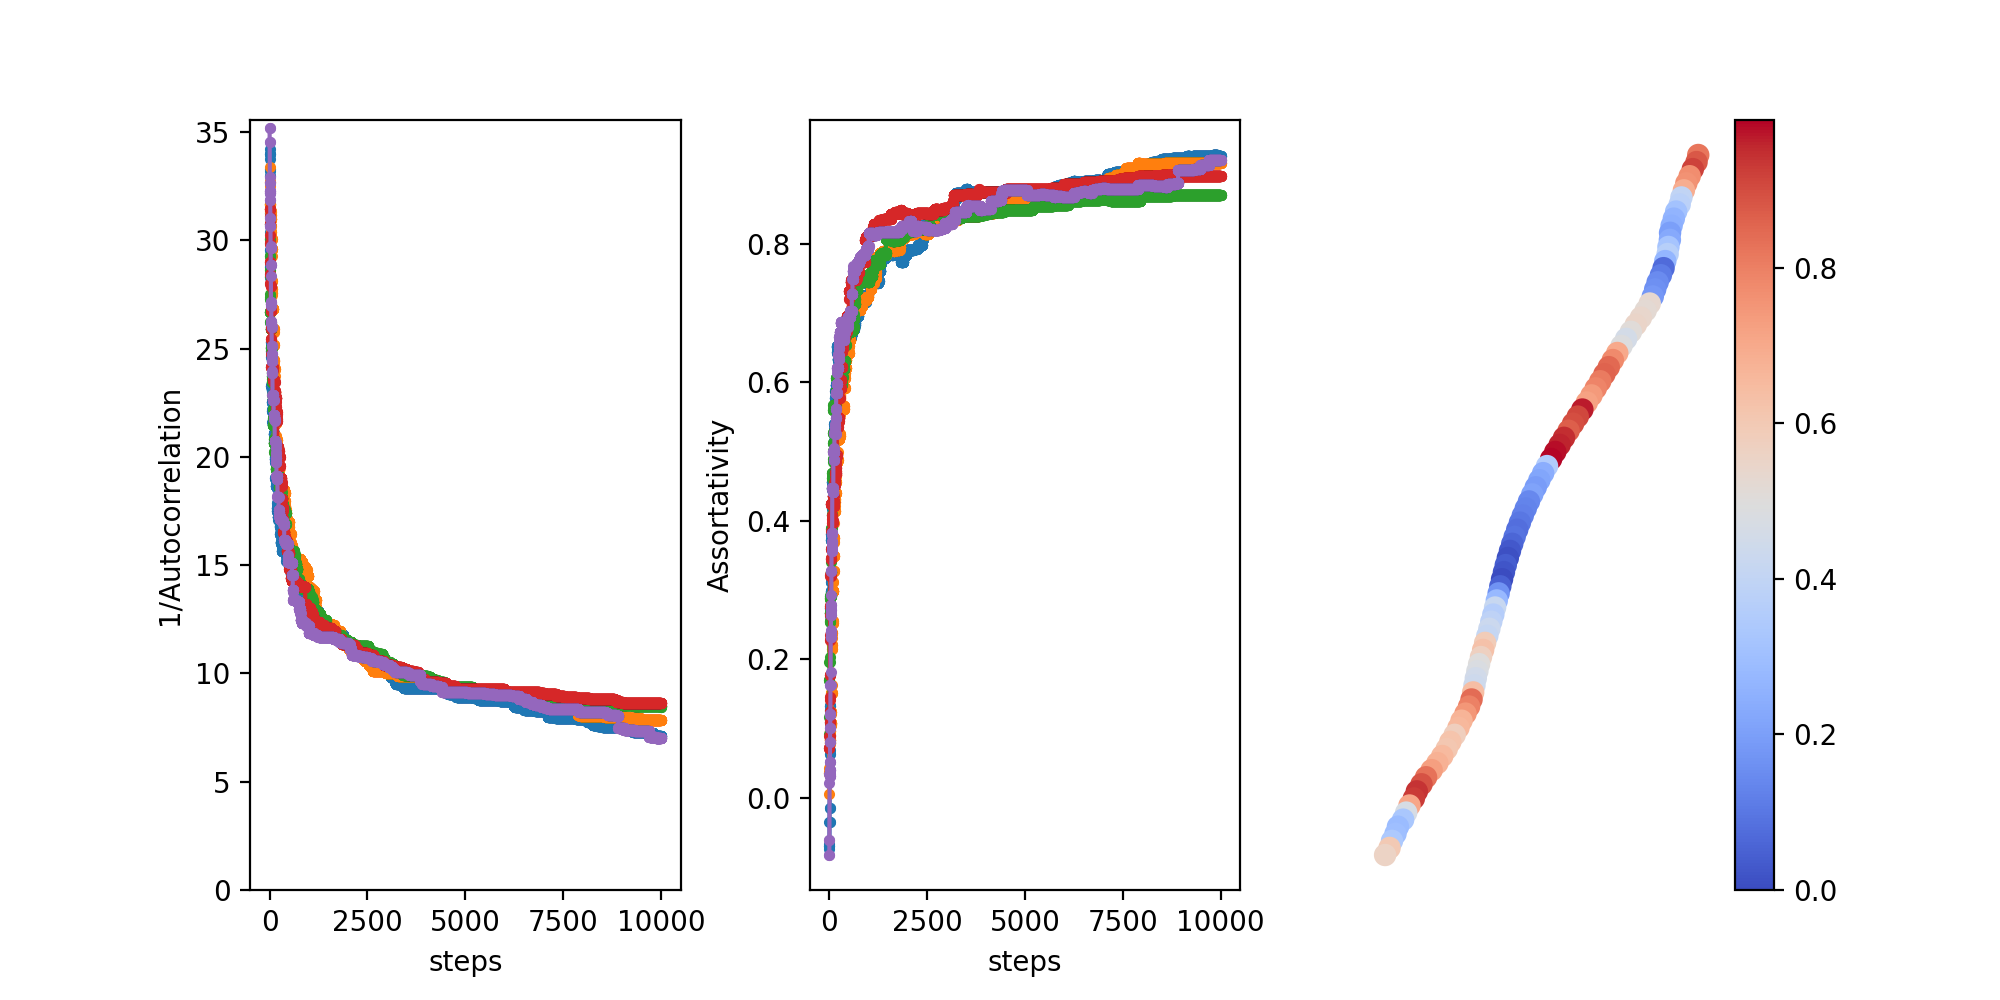

autocorrelation min & max: 7.109999999999999 34.20000000000002
autocorrelation min & max: 7.859999999999996 33.39
autocorrelation min & max: 8.449999999999996 30.770000000000003
autocorrelation min & max: 8.619999999999997 31.429999999999996
autocorrelation min & max: 7.019999999999997 35.18999999999999


In [7]:
# Spatial Autocorrelation optimization
fname = "N100linear.txt"
n_com = 100
m = np.loadtxt(fname,delimiter=' ')
n_sample = 4 # the number of nodes sample for env. condition swapping. Choose an even number
fig = plt.figure(figsize=[10,5])
for t in range(5):
    ASall,ASedge,g,attr,assort = envGen(n_com,m,n_sample)
    plt.subplot(131)
    plt.plot(range(len(ASall)),ASall,marker='.')
    plt.xlabel("steps")
    plt.ylabel("1/Autocorrelation")
    plt.ylim(bottom=0)
    plt.subplot(132)
    plt.plot(range(len(assort)),assort,marker='.')
    plt.xlabel("steps")
    plt.ylabel("Assortativity")
    print("autocorrelation min & max:",min(ASall),max(ASall))
plt.subplot(133)
Plot(g,attr)
fig.subplots_adjust(wspace=0.3)
plt.show()

<IPython.core.display.Javascript object>


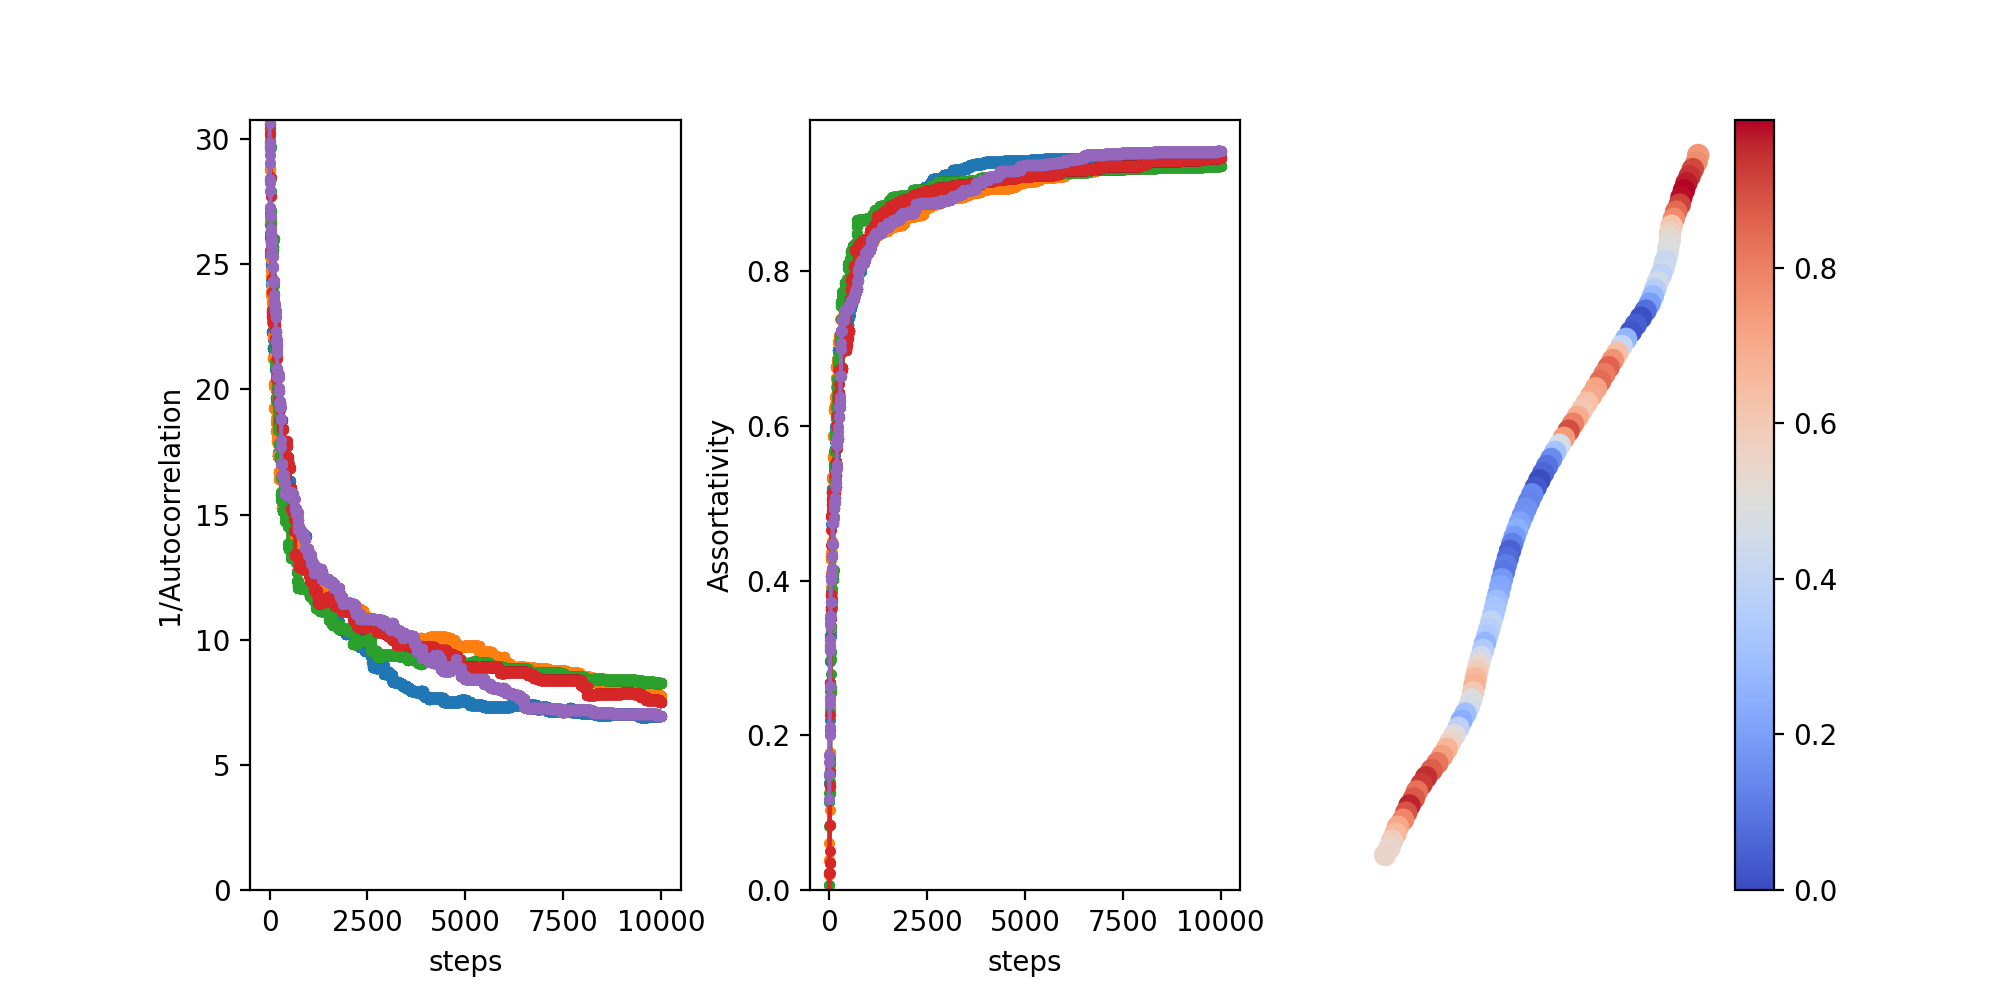

assortativity min & max: 0.11402609665641925 0.9532963728258866
autocorrelation of the final structure: (6.949999999999998, 0.07020202020202018)
assortativity min & max: -0.025345901239399164 0.9458555189827987
autocorrelation of the final structure: (7.739999999999997, 0.07818181818181814)
assortativity min & max: -0.05819472779655458 0.9360224746881823
autocorrelation of the final structure: (8.289999999999992, 0.08373737373737365)
assortativity min & max: -0.039538615605508816 0.9457894054429054
autocorrelation of the final structure: (7.529999999999996, 0.07606060606060602)
assortativity min & max: 0.11705006990551084 0.9551470740391343
autocorrelation of the final structure: (6.96, 0.0703030303030303)


In [8]:
# Assortativity optimization
fname = "N100linear.txt"
n_com = 100
m = np.loadtxt(fname,delimiter=' ')
n_sample = 4 # the number of nodes sample for env. condition swapping. Choose an even number
fig = plt.figure(figsize=[10,5])
for t in range(5):
    assort,g,attr,ASall = envGen_assort(n_com,m,n_sample)
    plt.subplot(131)
    plt.plot(range(len(ASall)),ASall,marker='.')
    plt.xlabel("steps")
    plt.ylabel("1/Autocorrelation")
    plt.ylim(bottom=0)
    plt.subplot(132)
    plt.plot(range(len(assort)),assort,marker='.')
    plt.xlabel("steps")
    plt.ylabel("Assortativity")
    plt.ylim(bottom=0)
    print("assortativity min & max:",min(assort),max(assort))
    print("autocorrelation of the final structure:",getAutocorrelation(g))
plt.subplot(133)
Plot(g,attr)
fig.subplots_adjust(wspace=0.3)
plt.show()

<IPython.core.display.Javascript object>


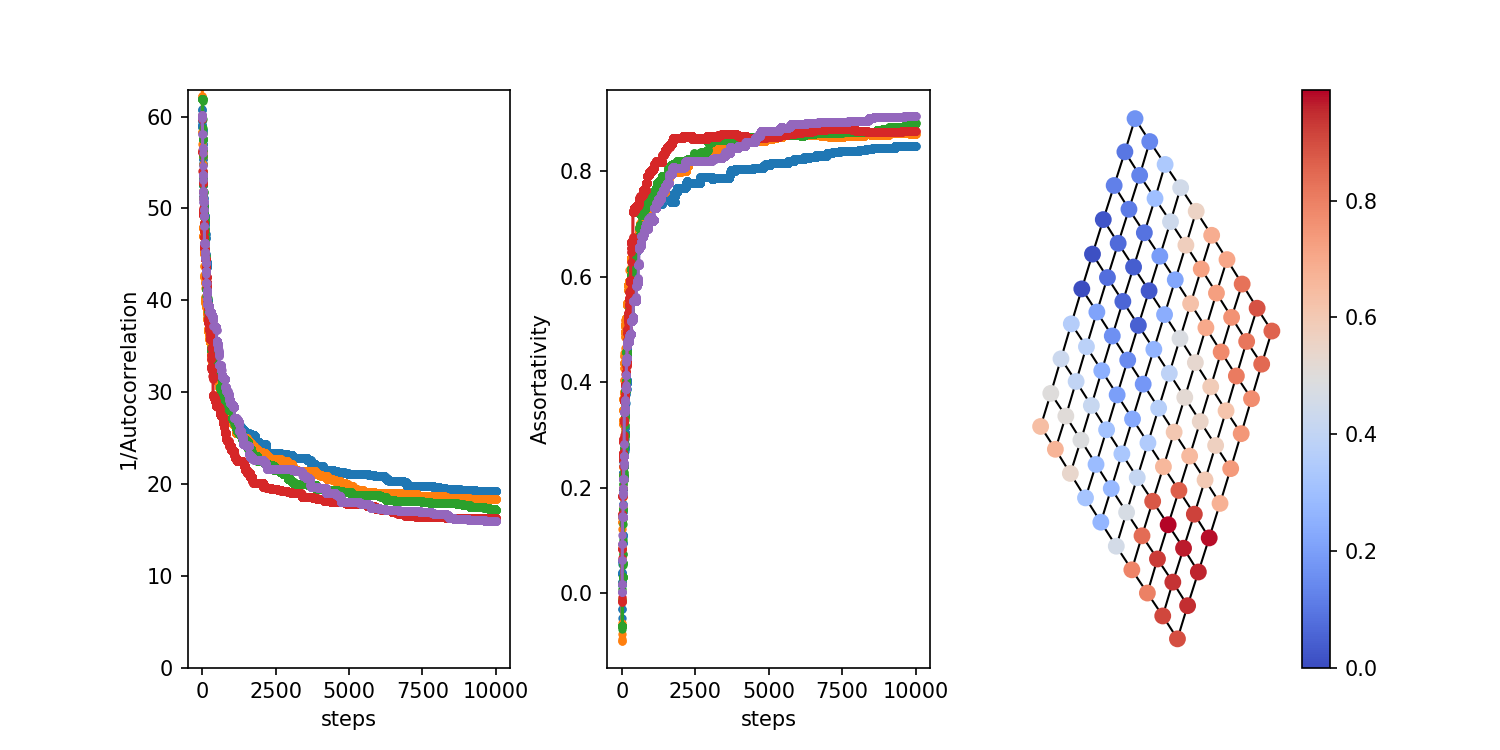

autocorrelation min & max: 19.24999999999999 60.82000000000001
autocorrelation min & max: 18.319999999999997 64.19999999999999
autocorrelation min & max: 17.14999999999999 61.94000000000001
autocorrelation min & max: 16.29999999999999 60.23000000000001
autocorrelation min & max: 15.969999999999988 60.20000000000002


In [26]:
# Spatial Autocorrelation optimization
fname = "N100grid.txt"
n_com = 100
m = np.loadtxt(fname,delimiter=' ')
n_sample = 4 # the number of nodes sample for env. condition swapping. Choose an even number
fig = plt.figure(figsize=[10,5])
for t in range(5):
    ASall,ASedge,g,attr,assort = envGen(n_com,m,n_sample)
    plt.subplot(131)
    plt.plot(range(len(ASall)),ASall,marker='.')
    plt.xlabel("steps")
    plt.ylabel("1/Autocorrelation")
    plt.ylim(bottom=0)
    plt.subplot(132)
    plt.plot(range(len(assort)),assort,marker='.')
    plt.xlabel("steps")
    plt.ylabel("Assortativity")
    print("autocorrelation min & max:",min(ASall),max(ASall))
plt.subplot(133)
Plot(g,attr)
fig.subplots_adjust(wspace=0.3)
plt.show()

<IPython.core.display.Javascript object>


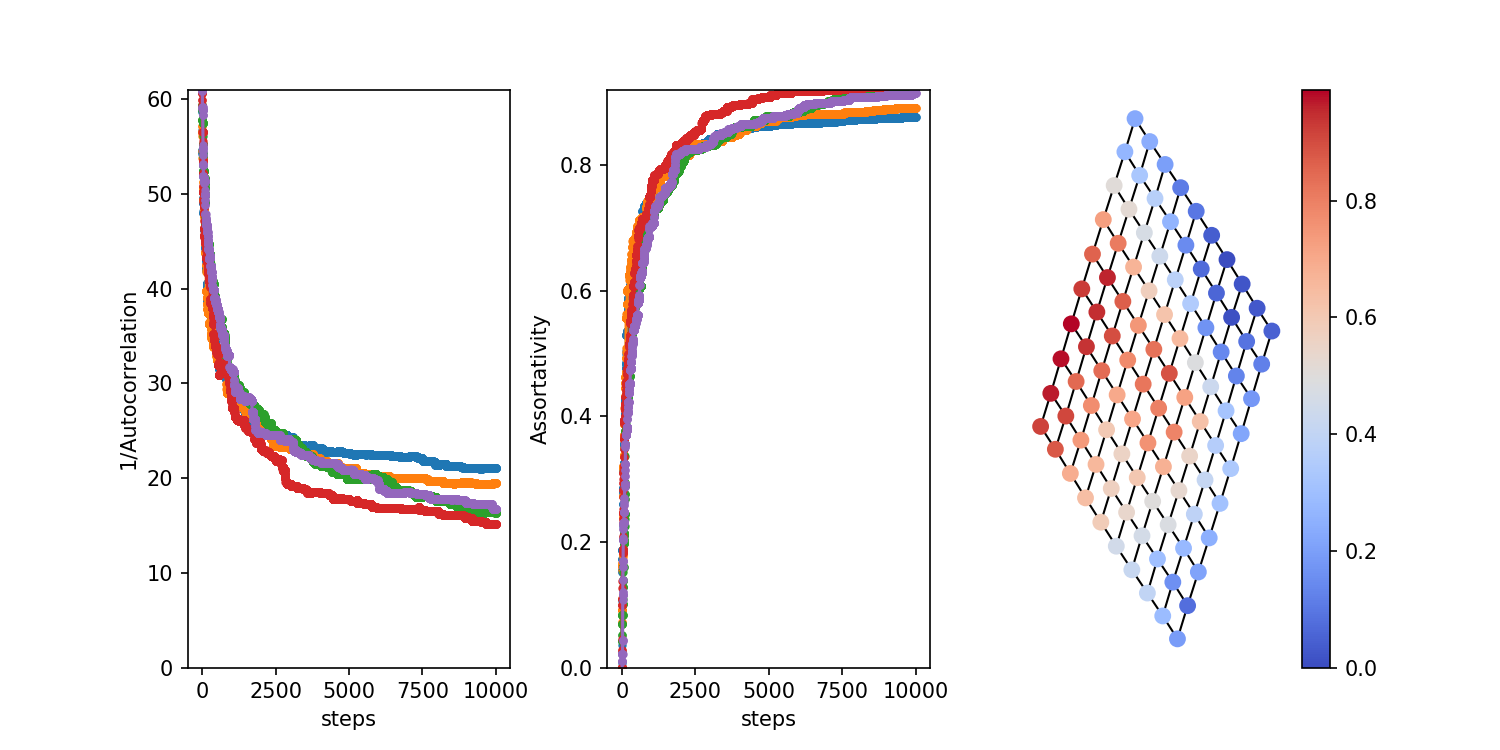

assortativity min & max: 0.0075839727787666185 0.8763907299750813
autocorrelation of the final structure: (21.039999999999985, 0.1168888888888888)
assortativity min & max: 0.07219410839551155 0.8911121708868537
autocorrelation of the final structure: (19.519999999999985, 0.10844444444444436)
assortativity min & max: 0.042322166153199066 0.9240722824269682
autocorrelation of the final structure: (16.349999999999994, 0.09083333333333331)
assortativity min & max: -0.010126259659728108 0.9300192594772401
autocorrelation of the final structure: (15.169999999999986, 0.0842777777777777)
assortativity min & max: -0.04138501900840819 0.9149279332655263
autocorrelation of the final structure: (16.769999999999992, 0.09316666666666662)


In [27]:
# Assortativity optimization
fname = "N100grid.txt"
n_com = 100
m = np.loadtxt(fname,delimiter=' ')
n_sample = 4 # the number of nodes sample for env. condition swapping. Choose an even number
fig = plt.figure(figsize=[10,5])
for t in range(5):
    assort,g,attr,ASall = envGen_assort(n_com,m,n_sample)
    plt.subplot(131)
    plt.plot(range(len(ASall)),ASall,marker='.')
    plt.xlabel("steps")
    plt.ylabel("1/Autocorrelation")
    plt.ylim(bottom=0)
    plt.subplot(132)
    plt.plot(range(len(assort)),assort,marker='.')
    plt.xlabel("steps")
    plt.ylabel("Assortativity")
    plt.ylim(bottom=0)
    print("assortativity min & max:",min(assort),max(assort))
    print("autocorrelation of the final structure:",getAutocorrelation(g))
plt.subplot(133)
Plot(g,attr)
fig.subplots_adjust(wspace=0.3)
plt.show()

<IPython.core.display.Javascript object>


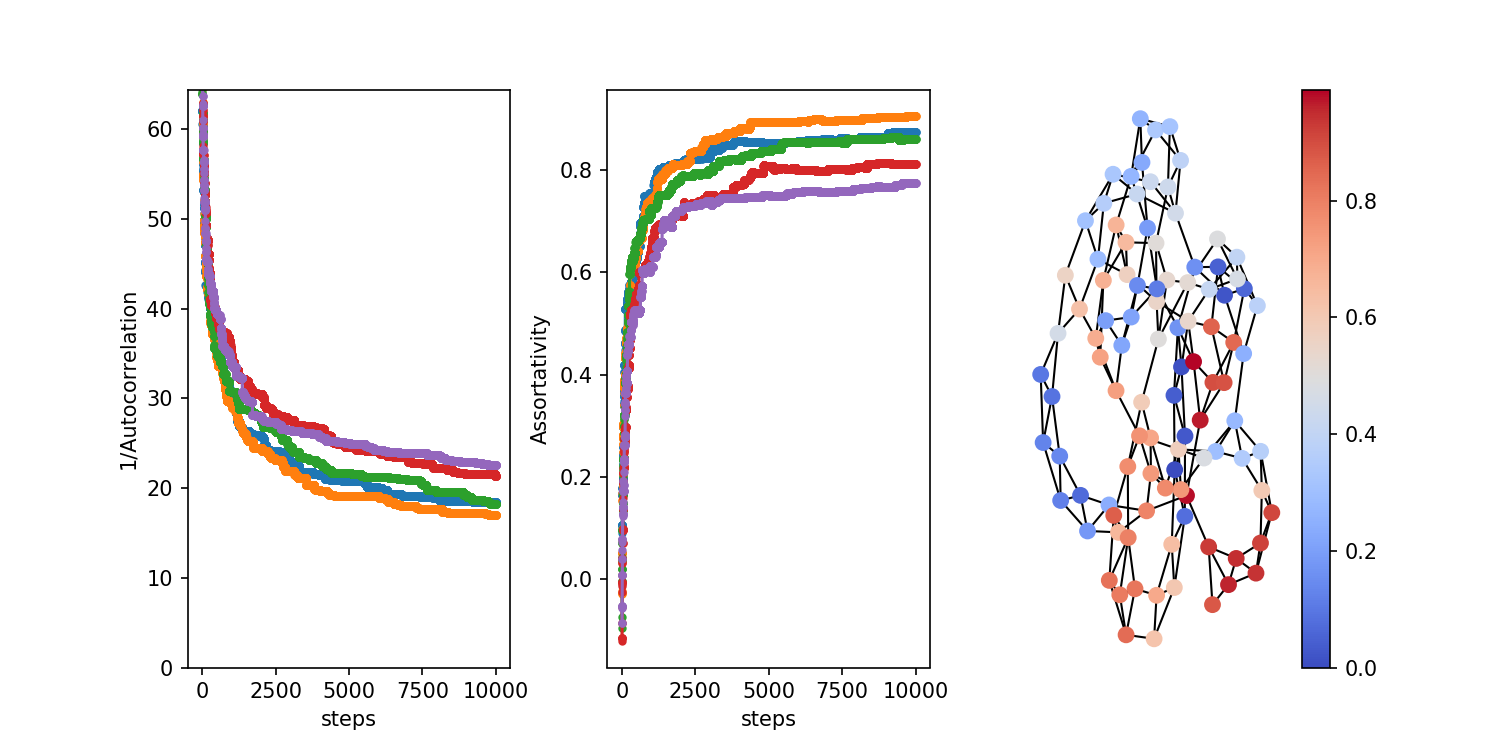

autocorrelation min & max: 18.399999999999977 62.16000000000004
assortativity min & max: 0.09134167850668815 0.872522492916862
autocorrelation min & max: 17.009999999999984 69.49
assortativity min & max: -0.027905183477734952 0.9041891488361533
autocorrelation min & max: 18.24 70.47999999999996
assortativity min & max: -0.09443310701609355 0.8645601638804206
autocorrelation min & max: 21.369999999999994 69.73000000000002
assortativity min & max: -0.1207575171664186 0.8133464687605545
autocorrelation min & max: 22.59000000000001 70.11000000000001
assortativity min & max: -0.0854658239660647 0.7737469324912502


In [28]:
# Spatial Autocorrelation optimization
fname = "N100sw.txt"
n_com = 100
m = np.loadtxt(fname,delimiter=' ')
n_sample = 4 # the number of nodes sample for env. condition swapping. Choose an even number
fig = plt.figure(figsize=[10,5])
for t in range(5):
    ASall,ASedge,g,attr,assort = envGen(n_com,m,n_sample)
    plt.subplot(131)
    plt.plot(range(len(ASall)),ASall,marker='.')
    plt.xlabel("steps")
    plt.ylabel("1/Autocorrelation")
    plt.ylim(bottom=0)
    plt.subplot(132)
    plt.plot(range(len(assort)),assort,marker='.')
    plt.xlabel("steps")
    plt.ylabel("Assortativity")
    print("autocorrelation min & max:",min(ASall),max(ASall))
    print("assortativity min & max:",min(assort),max(assort))
plt.subplot(133)
Plot(g,attr)
fig.subplots_adjust(wspace=0.3)
plt.show()

<IPython.core.display.Javascript object>


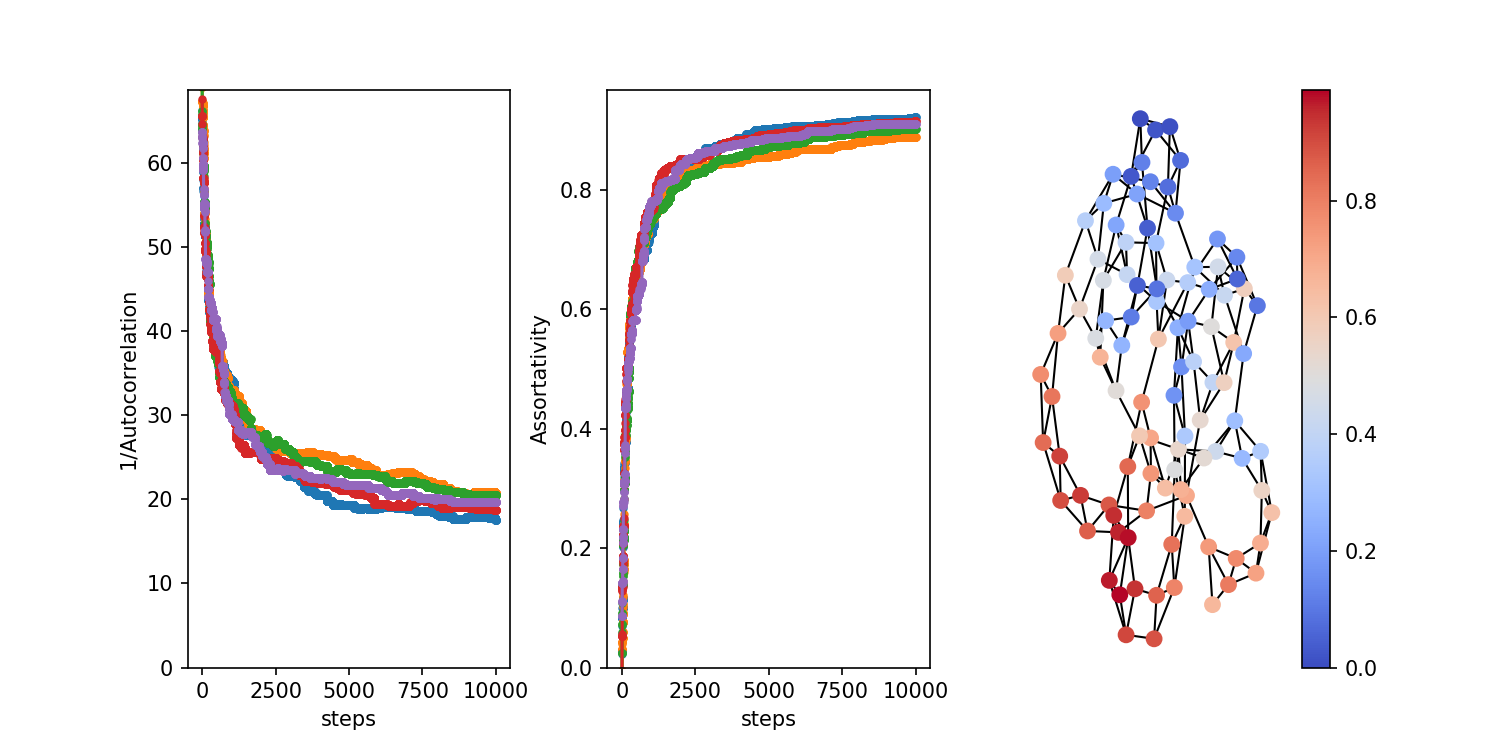

assortativity min & max: 0.022747566113386353 0.9227686255777264
autocorrelation min & max: 17.49999999999999 66.27000000000002
assortativity min & max: -0.080313575980274 0.8889430112127733
autocorrelation min & max: 20.639999999999986 70.07000000000001
assortativity min & max: -0.04967432116983661 0.9019035225976233
autocorrelation min & max: 20.519999999999996 69.46000000000001
assortativity min & max: -0.015368016271708296 0.9149920879649934
autocorrelation min & max: 18.689999999999994 67.60999999999996
assortativity min & max: 0.08602284679078305 0.9114457789927702
autocorrelation min & max: 19.650000000000002 63.72999999999998


In [29]:
# Assortativity optimization
fname = "N100sw.txt"
n_com = 100
m = np.loadtxt(fname,delimiter=' ')
n_sample = 4 # the number of nodes sample for env. condition swapping. Choose an even number
fig = plt.figure(figsize=[10,5])
for t in range(5):
    assort,g,attr,ASall = envGen_assort(n_com,m,n_sample)
    plt.subplot(131)
    plt.plot(range(len(ASall)),ASall,marker='.')
    plt.xlabel("steps")
    plt.ylabel("1/Autocorrelation")
    plt.ylim(bottom=0)
    plt.subplot(132)
    plt.plot(range(len(assort)),assort,marker='.')
    plt.xlabel("steps")
    plt.ylabel("Assortativity")
    plt.ylim(bottom=0)
    print("assortativity min & max:",min(assort),max(assort))
    print("autocorrelation min & max:", min(ASall), max(ASall))
plt.subplot(133)
Plot(g,attr)
fig.subplots_adjust(wspace=0.3)
plt.show()

<IPython.core.display.Javascript object>


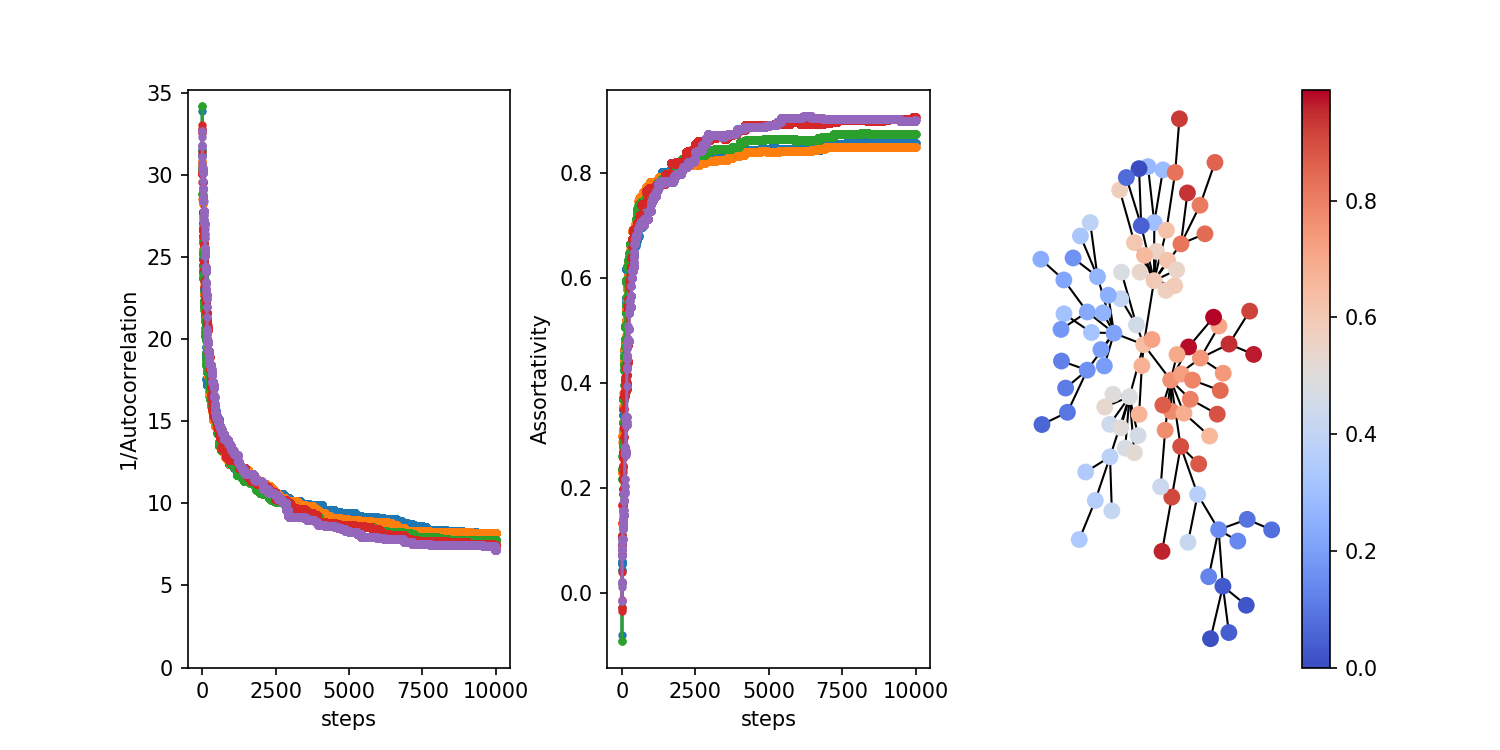

autocorrelation min & max: 8.209999999999992 33.879999999999995
assortativity min & max: -0.08160744451215662 0.8612934447196267
autocorrelation min & max: 8.199999999999992 30.78000000000002
assortativity min & max: 0.10325730950939654 0.8496960054413418
autocorrelation min & max: 7.739999999999996 34.19
assortativity min & max: -0.09275682777612408 0.8760102215013557
autocorrelation min & max: 7.4499999999999975 33.040000000000006
assortativity min & max: -0.03468831413642875 0.9054509286746474
autocorrelation min & max: 7.179999999999992 32.65000000000001
assortativity min & max: -0.016036486080481634 0.9076918737779793


In [30]:
# Spatial Autocorrelation optimization
fname = "N100sf.txt"
n_com = 100
m = np.loadtxt(fname,delimiter=' ')
n_sample = 4 # the number of nodes sample for env. condition swapping. Choose an even number
fig = plt.figure(figsize=[10,5])
for t in range(5):
    ASall,ASedge,g,attr,assort = envGen(n_com,m,n_sample)
    plt.subplot(131)
    plt.plot(range(len(ASall)),ASall,marker='.')
    plt.xlabel("steps")
    plt.ylabel("1/Autocorrelation")
    plt.ylim(bottom=0)
    plt.subplot(132)
    plt.plot(range(len(assort)),assort,marker='.')
    plt.xlabel("steps")
    plt.ylabel("Assortativity")
    print("autocorrelation min & max:",min(ASall),max(ASall))
    print("assortativity min & max:", min(assort), max(assort))
plt.subplot(133)
Plot(g,attr)
fig.subplots_adjust(wspace=0.3)
plt.show()

<IPython.core.display.Javascript object>


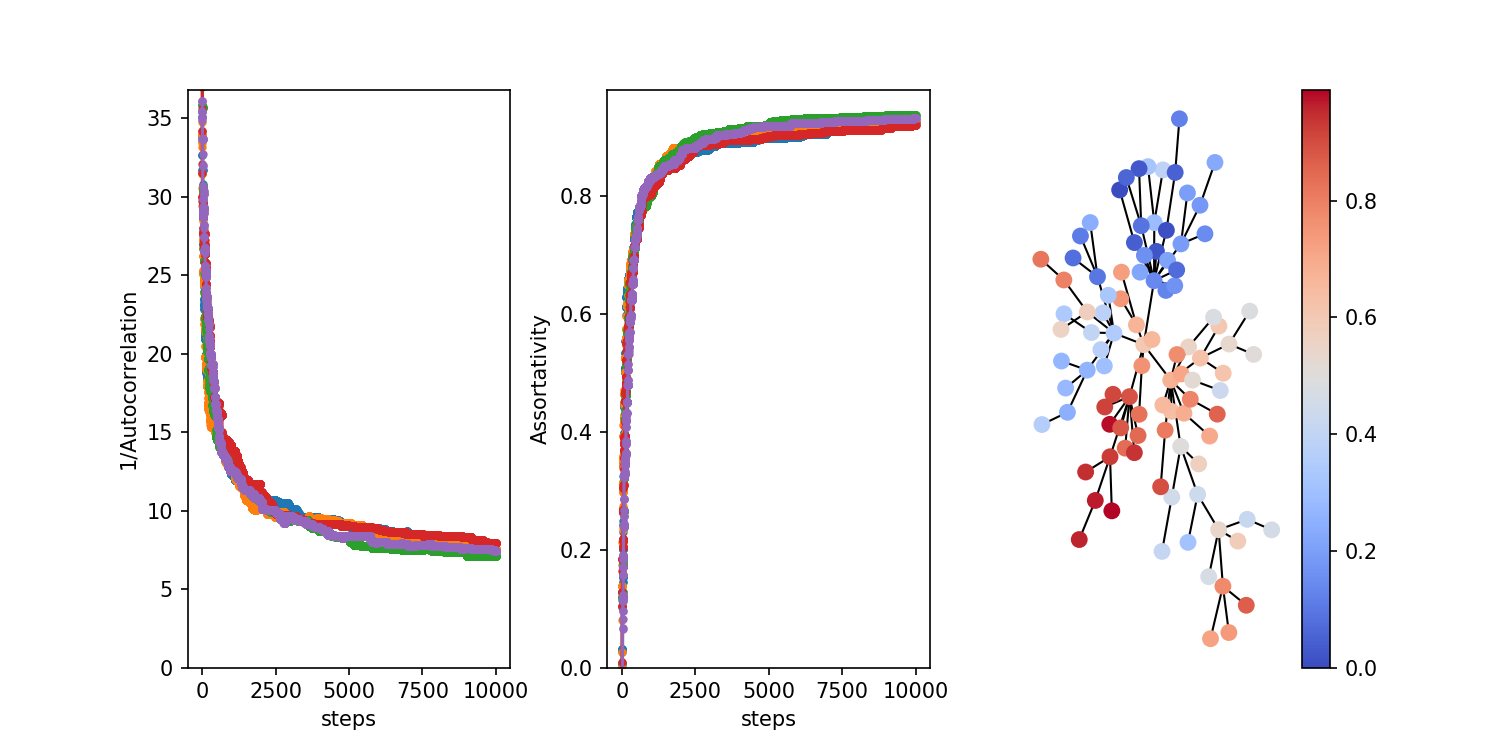

assortativity min & max: -0.16979046317208016 0.9244398177581549
autocorrelation min & max: 7.419999999999992 35.40999999999999
assortativity min & max: -0.06045676017151612 0.9282042606353226
autocorrelation min & max: 7.579999999999999 34.77
assortativity min & max: -0.1183804578890188 0.9375089677157016
autocorrelation min & max: 7.079999999999993 37.85999999999999
assortativity min & max: -0.23357491246578704 0.9202611572037446
autocorrelation min & max: 7.909999999999997 37.220000000000006
assortativity min & max: -0.1862934024736336 0.9314190274584371
autocorrelation min & max: 7.4199999999999955 36.10000000000001


In [37]:
# Assortativity optimization
fname = "N100sf.txt"
n_com = 100
m = np.loadtxt(fname,delimiter=' ')
n_sample = 4 # the number of nodes sample for env. condition swapping. Choose an even number
fig = plt.figure(figsize=[10,5])
for t in range(5):
    assort,g,attr,ASall = envGen_assort(n_com,m,n_sample)
    plt.subplot(131)
    plt.plot(range(len(ASall)),ASall,marker='.')
    plt.xlabel("steps")
    plt.ylabel("1/Autocorrelation")
    plt.ylim(bottom=0)
    plt.subplot(132)
    plt.plot(range(len(assort)),assort,marker='.')
    plt.xlabel("steps")
    plt.ylabel("Assortativity")
    plt.ylim(bottom=0)
    print("assortativity min & max:",min(assort),max(assort))
    print("autocorrelation min & max:", min(ASall), max(ASall))
plt.subplot(133)
Plot(g,attr)
fig.subplots_adjust(wspace=0.3)
plt.show()

<IPython.core.display.Javascript object>


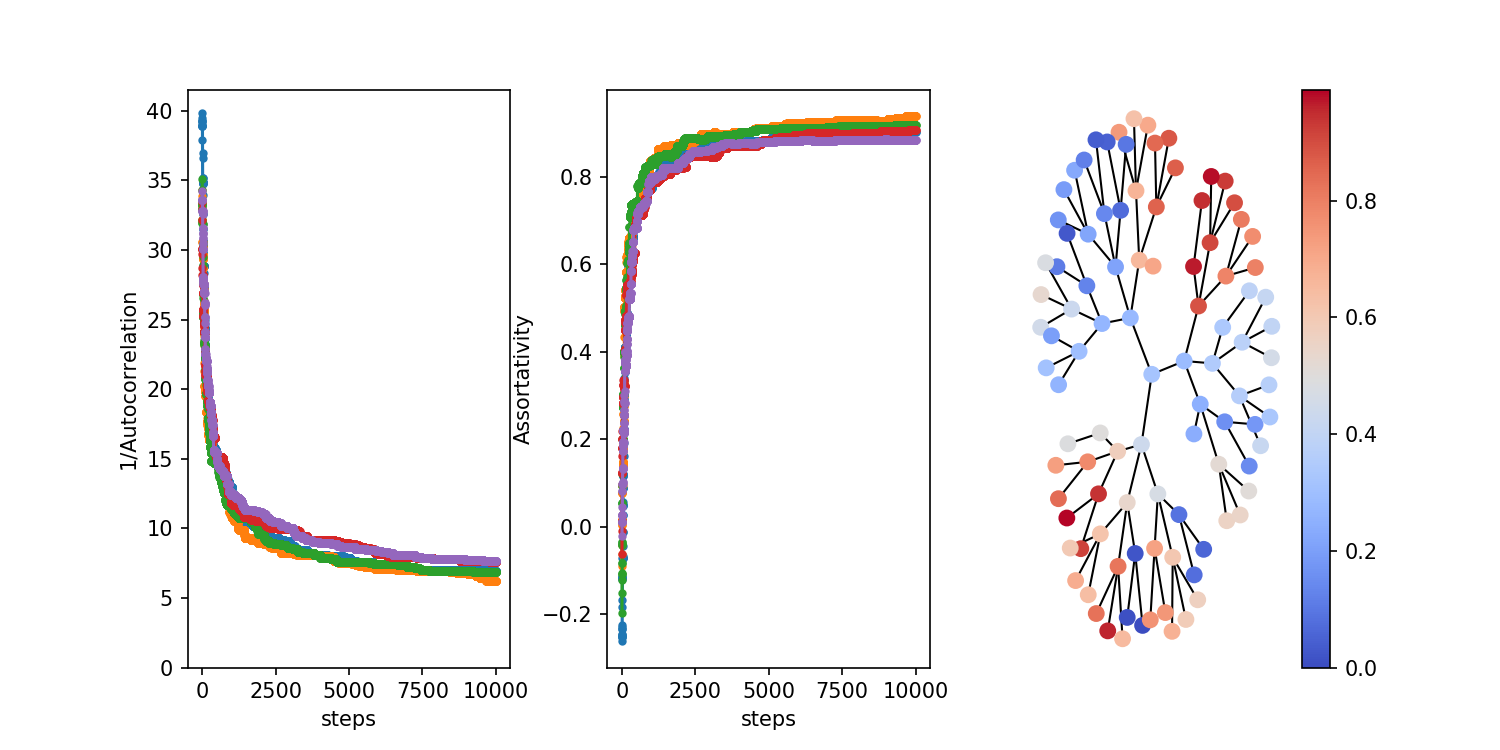

autocorrelation min & max: 6.929999999999995 39.85000000000001
assortativity min & max: -0.2625103990464137 0.9022086712656896
autocorrelation min & max: 6.199999999999994 34.32999999999999
assortativity min & max: -0.09103334059719066 0.9390872035130734
autocorrelation min & max: 6.8399999999999945 35.08
assortativity min & max: -0.19775687162900812 0.9188502166509529
autocorrelation min & max: 7.549999999999992 33.43000000000001
assortativity min & max: -0.062332582965789855 0.9065163385062264
autocorrelation min & max: 7.669999999999995 34.220000000000006
assortativity min & max: -0.02260710579631475 0.8859379067295985


In [38]:
# Spatial Autocorrelation optimization
fname = "N100tree.txt"
n_com = 100
m = np.loadtxt(fname,delimiter=' ')
n_sample = 4 # the number of nodes sample for env. condition swapping. Choose an even number
fig = plt.figure(figsize=[10,5])
for t in range(5):
    ASall,ASedge,g,attr,assort = envGen(n_com,m,n_sample)
    plt.subplot(131)
    plt.plot(range(len(ASall)),ASall,marker='.')
    plt.xlabel("steps")
    plt.ylabel("1/Autocorrelation")
    plt.ylim(bottom=0)
    plt.subplot(132)
    plt.plot(range(len(assort)),assort,marker='.')
    plt.xlabel("steps")
    plt.ylabel("Assortativity")
    print("autocorrelation min & max:",min(ASall),max(ASall))
    print("assortativity min & max:", min(assort), max(assort))
plt.subplot(133)
Plot(g,attr)
fig.subplots_adjust(wspace=0.3)
plt.show()

In [ ]:
# Assortativity optimization
fname = "N100tree.txt"
n_com = 100
m = np.loadtxt(fname,delimiter=' ')
n_sample = 4 # the number of nodes sample for env. condition swapping. Choose an even number
fig = plt.figure(figsize=[10,5])
for t in range(5):
    assort,g,attr,ASall = envGen_assort(n_com,m,n_sample)
    plt.subplot(131)
    plt.plot(range(len(ASall)),ASall,marker='.')
    plt.xlabel("steps")
    plt.ylabel("1/Autocorrelation")
    plt.ylim(bottom=0)
    plt.subplot(132)
    plt.plot(range(len(assort)),assort,marker='.')
    plt.xlabel("steps")
    plt.ylabel("Assortativity")
    plt.ylim(bottom=0)
    print("assortativity min & max:",min(assort),max(assort))
    print("autocorrelation min & max:", min(ASall), max(ASall))
plt.subplot(133)
Plot(g,attr)
fig.subplots_adjust(wspace=0.3)
plt.show()

In [31]:
def envGen2(n_com,m,n_sample,th,seed=None):
    g = nx.Graph(m)
    e = 1 / float(n_com)
    E_ls = np.arange(0,(n_com-1)*e+e,e)
    np.random.seed(seed)
    np.random.shuffle(E_ls)
    attr = {i:E_ls[i] for i in range(n_com)}
    nx.set_node_attributes(g,attr,"E")
    ASall = []
    ASedge = []
    AS = getAutocorrelation(g)
    ASall.append(AS[0])
    ASedge.append(AS[1])
    c = 0
    while (ASall[-1] > th) & (c < 11000):
        n_ls = np.random.choice(range(n_com),n_sample,replace=False)
        nPair = int(n_sample/2)
        a = np.random.choice(n_ls,nPair,replace=False)
        b = [x for x in n_ls if x not in a]
        np.random.shuffle(a)
        np.random.shuffle(b)
        gcopy = deepcopy(g)
        for n1,n2 in zip(a,b): # swap environmental conditions
            gcopy.nodes()[n1]['E'] = g.nodes()[n2]['E']
            gcopy.nodes()[n2]['E'] = g.nodes()[n1]['E']
        AS_copy = getAutocorrelation(gcopy)
        if AS_copy[0] < ASall[-1]:
            g = gcopy # update g
            ASall.append(AS_copy[0])
            ASedge.append(AS_copy[1])
        c += 1
    attr = dict(g.nodes(data='E'))
    return ASall[-1],ASedge[-1],g,attr

<IPython.core.display.Javascript object>


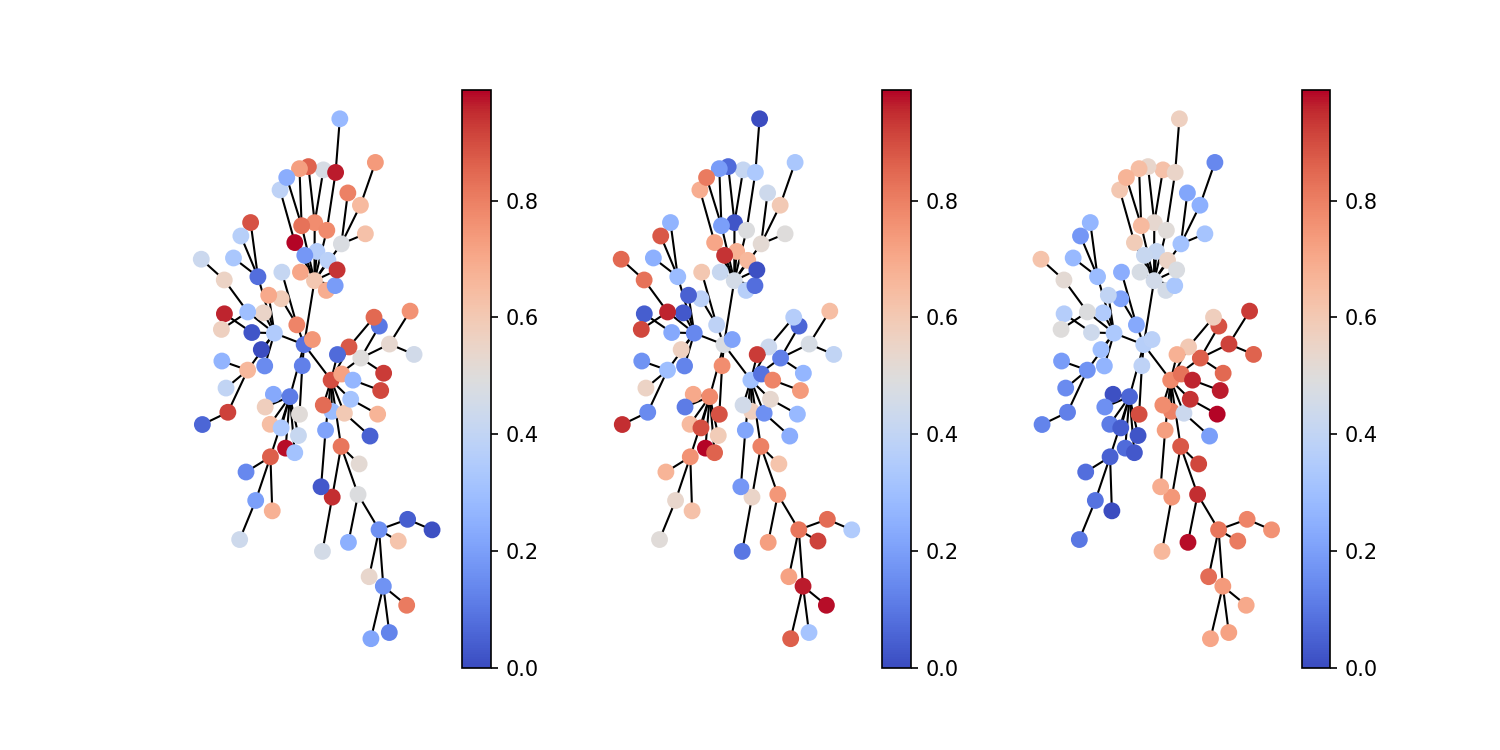

33.12000000000002 0.33454545454545476
19.890000000000004 0.20090909090909095
7.109999999999993 0.07181818181818175


In [32]:
name = "N100sf"
th_ls = [1000,20,0] # th=1000 is just to get the largest, th=0 to get the smallest autocorrelations
n_com = 100
m = np.loadtxt(name+".txt",delimiter=' ')
n_sample = 4 # the number of nodes sample for env. condition swapping. Choose an even number
fig = plt.figure(figsize=[10,5])
for t,th in enumerate(th_ls):
    ASall,ASedge,g,attr = envGen2(n_com,m,n_sample,th)
    print(ASall,ASedge)
    attr = nx.get_node_attributes(g,'E')
    np.savetxt(name+"_"+str(ASall),list(attr.values()))
    plt.subplot(1,3,t+1)
    Plot(g,attr)
    fig.subplots_adjust(wspace=0.3)
    plt.show()

<IPython.core.display.Javascript object>


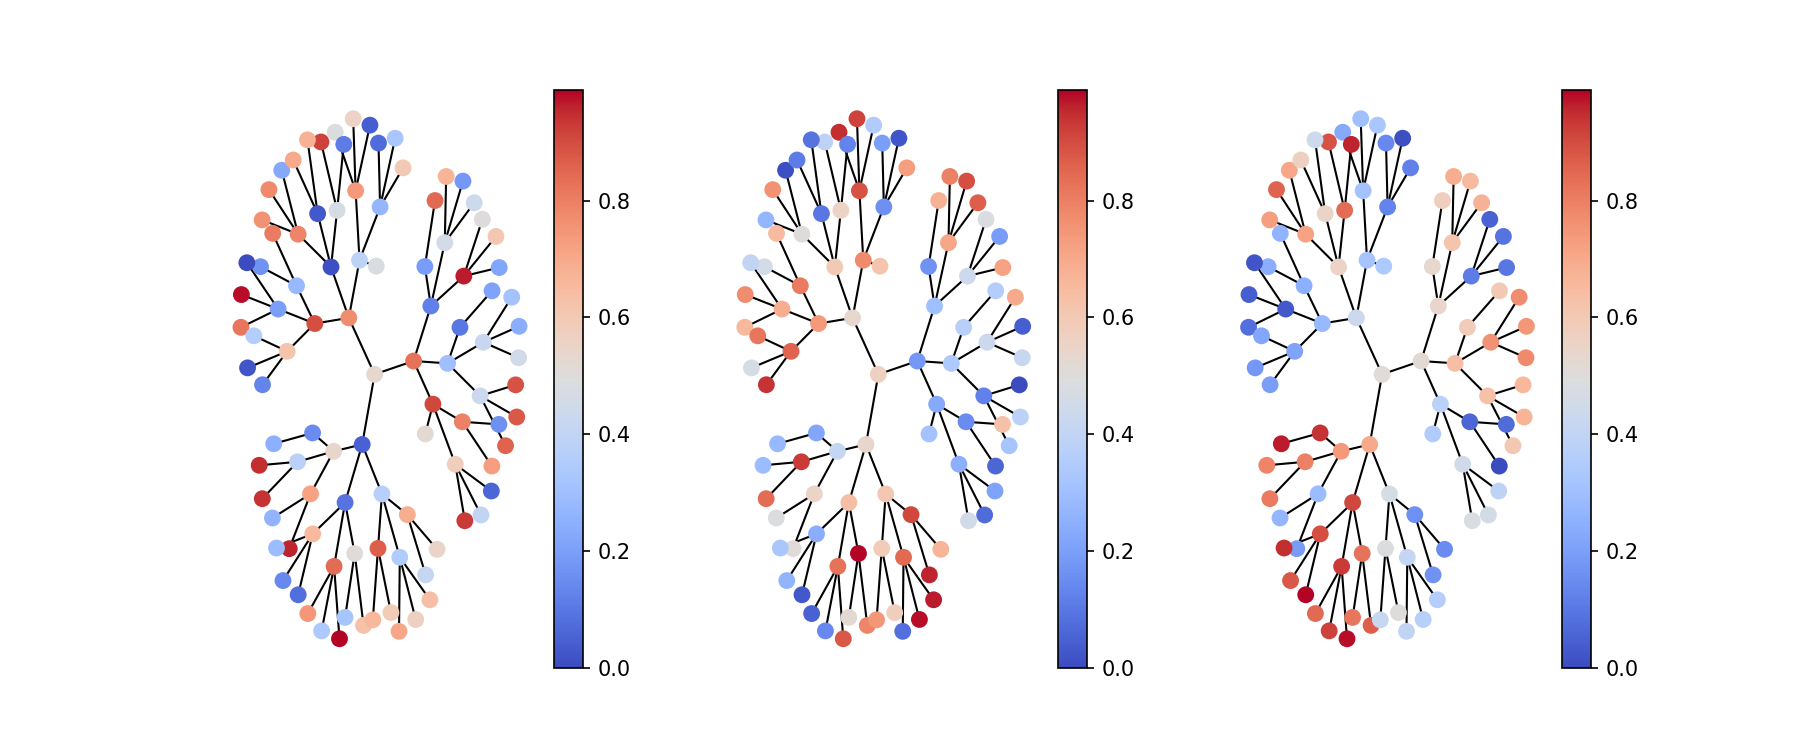

34.24000000000001 0.345858585858586
19.990000000000006 0.20191919191919197
6.959999999999993 0.07030303030303023


In [33]:
name = "N100tree"
th_ls = [1000,20,0] # th=1000 is just to get the largest, th=0 to get the smallest autocorrelations
n_com = 100
m = np.loadtxt(name+".txt",delimiter=' ')
n_sample = 4 # the number of nodes sample for env. condition swapping. Choose an even number
fig = plt.figure(figsize=[12,5])
for t,th in enumerate(th_ls):
    ASall,ASedge,g,attr = envGen2(n_com,m,n_sample,th)
    print(ASall,ASedge)
    attr = nx.get_node_attributes(g,'E')
    np.savetxt(name+"_"+str(ASall),list(attr.values()))
    plt.subplot(1,3,t+1)
    Plot(g,attr)
    fig.subplots_adjust(wspace=0.3)
plt.show()

<IPython.core.display.Javascript object>


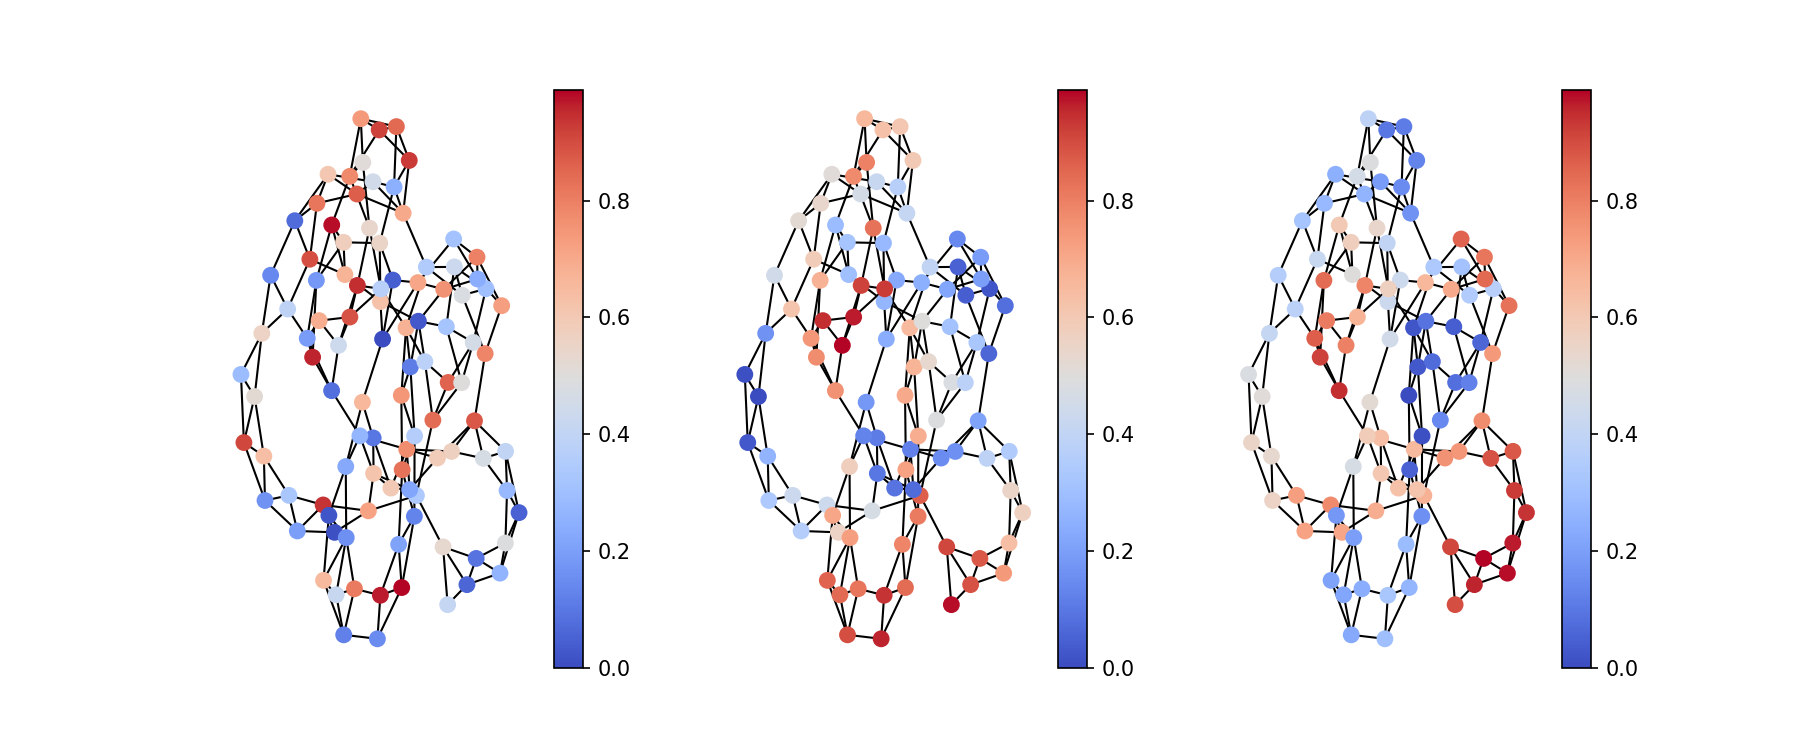

65.38000000000001 0.3269
20.519999999999996 0.10259999999999998
17.65999999999998 0.08829999999999989


In [34]:
name = "N100sw"
th_ls = [1000,20,0] # th=1000 is just to get the largest, th=0 to get the smallest autocorrelations
n_com = 100
m = np.loadtxt(name+".txt",delimiter=' ')
n_sample = 4 # the number of nodes sample for env. condition swapping. Choose an even number
fig = plt.figure(figsize=[12,5])
for t,th in enumerate(th_ls):
    ASall,ASedge,g,attr = envGen2(n_com,m,n_sample,th)
    print(ASall,ASedge)
    attr = nx.get_node_attributes(g,'E')
    np.savetxt(name+"_"+str(ASall),list(attr.values()))
    plt.subplot(1,3,t+1)
    Plot(g,attr)
    fig.subplots_adjust(wspace=0.3)
plt.show()

<IPython.core.display.Javascript object>


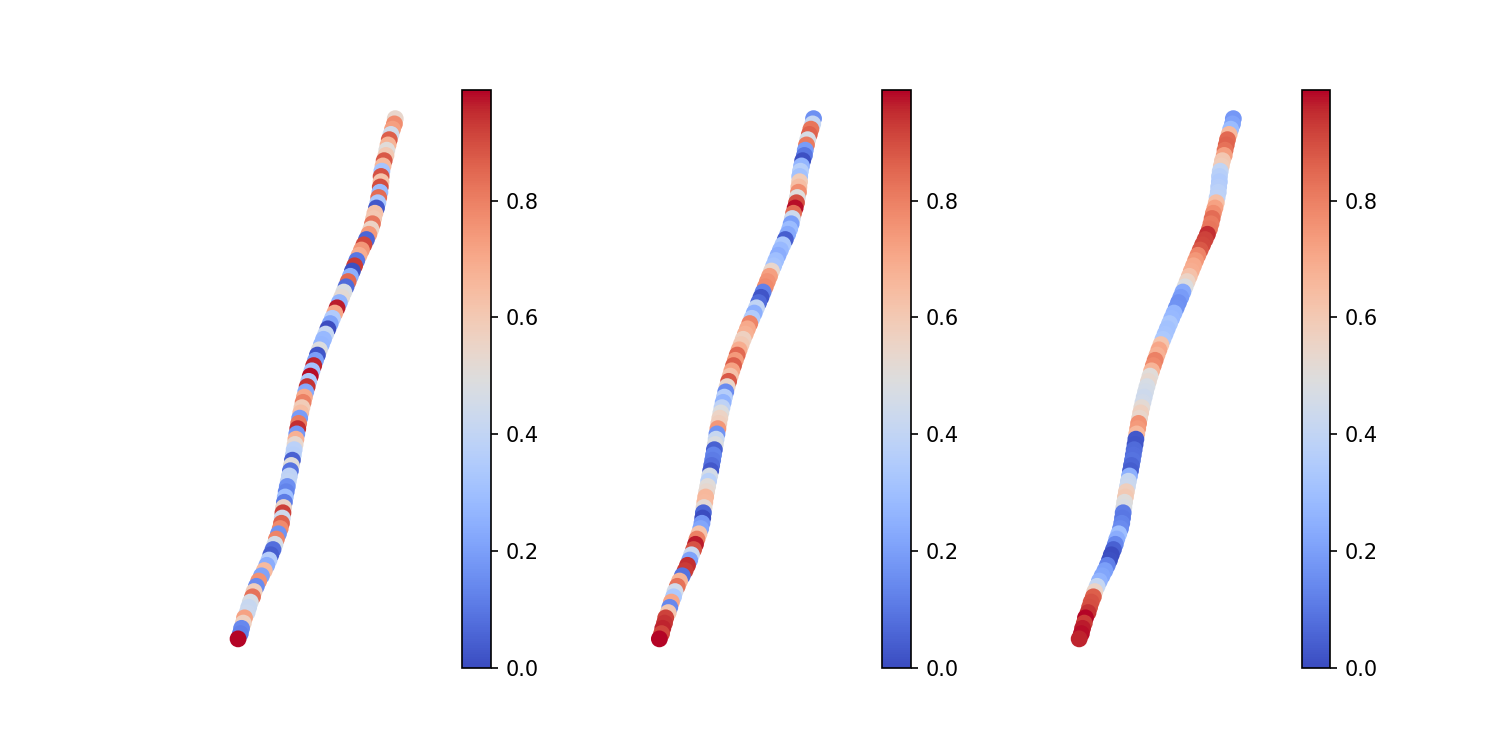

34.99 0.35343434343434343
19.890000000000004 0.20090909090909095
7.6999999999999975 0.07777777777777775


In [35]:
name = "N100linear"
th_ls = [1000,20,0] # th=1000 is just to get the largest, th=0 to get the smallest autocorrelations
n_com = 100
m = np.loadtxt(name+".txt",delimiter=' ')
n_sample = 4 # the number of nodes sample for env. condition swapping. Choose an even number
fig = plt.figure(figsize=[10,5])
for t,th in enumerate(th_ls):
    ASall,ASedge,g,attr = envGen2(n_com,m,n_sample,th)
    print(ASall,ASedge)
    attr = nx.get_node_attributes(g,'E')
    np.savetxt(name+"_"+str(ASall),list(attr.values()))
    plt.subplot(1,3,t+1)
    Plot(g,attr)
    fig.subplots_adjust(wspace=0.3)
    plt.show()

<IPython.core.display.Javascript object>


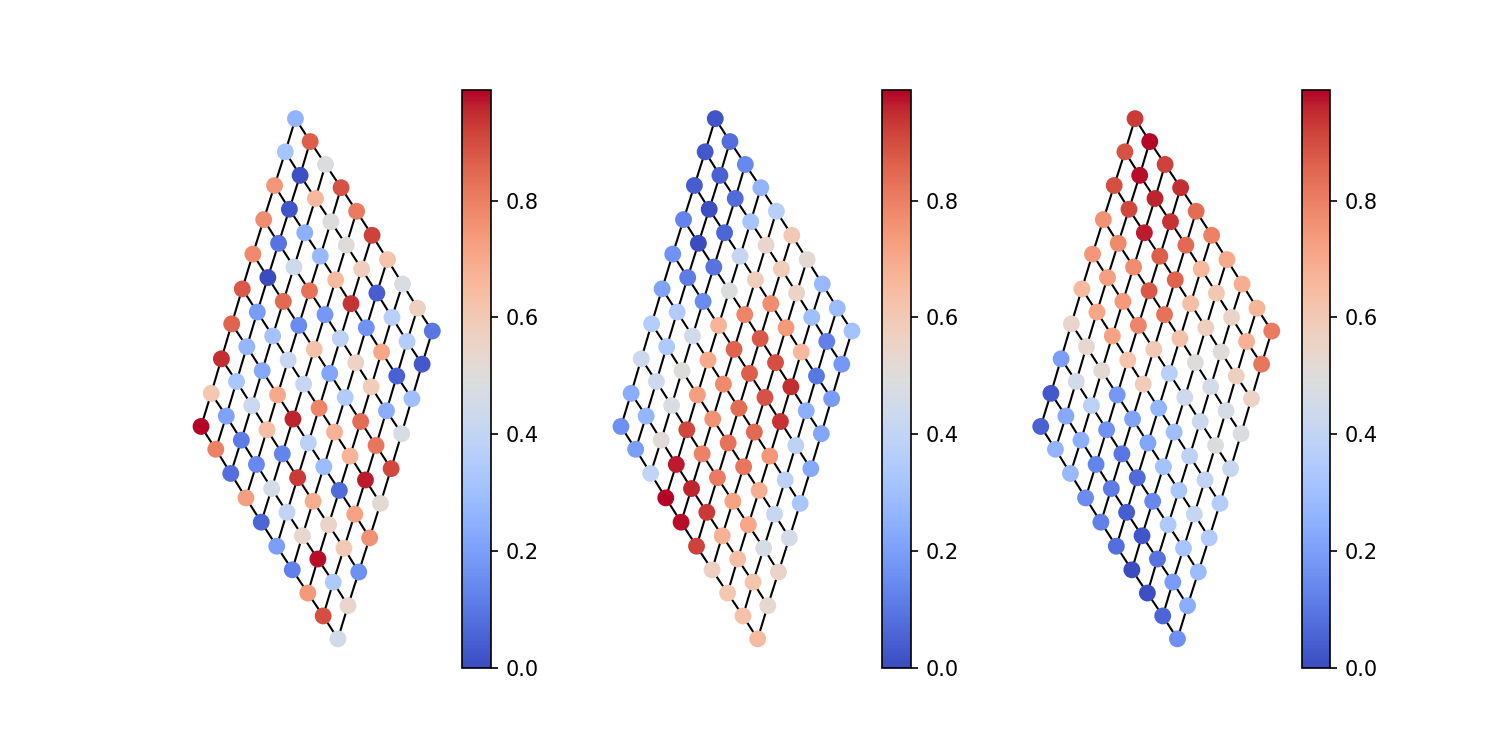

57.910000000000004 0.32172222222222224
19.939999999999987 0.11077777777777771
14.659999999999991 0.0814444444444444


In [36]:
name = "N100grid"
th_ls = [1000,20,0] # th=1000 is just to get the largest, th=0 to get the smallest autocorrelations
n_com = 100
m = np.loadtxt(name+".txt",delimiter=' ')
n_sample = 4 # the number of nodes sample for env. condition swapping. Choose an even number
fig = plt.figure(figsize=[10,5])
for t,th in enumerate(th_ls):
    ASall,ASedge,g,attr = envGen2(n_com,m,n_sample,th)
    print(ASall,ASedge)
    attr = nx.get_node_attributes(g,'E')
    np.savetxt(name+"_"+str(ASall),list(attr.values()))
    plt.subplot(1,3,t+1)
    Plot(g,attr)
    fig.subplots_adjust(wspace=0.3)
    plt.show()